## DistilBERT Fine-Tuning 

In [ ]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import *
import helpers as helpers
import torch.nn as nn
import random
import os
import shutil
from pathlib import Path

/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# DistilBERT: max_len=128–256, batch_size=16, lr≈2e-5, epochs=2–3, early stopping.

MODEL_NAME = "bert"

DEPRESSION_PATH = "data/depression_dataset_reddit_cleaned.csv"
TDT_SPLIT = "80/10/10"
BERT_MODEL = 'distilbert-base-uncased'
N_GRAM = 2

MAX_LENGTH = 256

# default hyperparameters
BATCH_SIZE = 16
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01

# hyperparameter tuning
HYPERPARAMETER_TUNING = True  # Set to false to use default
N_TRIALS = 10 
RANDOM_SEED = 42

PARAM_RANGES = {
    'learning_rate': [1e-5, 2e-5, 3e-5, 5e-5],  # Using common BERT learning rates
    'batch_size': [8, 16, 32],
    'num_epochs': [2, 3, 4],
    'weight_decay': [0.0, 0.01, 0.1]
}

In [3]:
data, labels = helpers.get_data(datapath=DEPRESSION_PATH, ngram=N_GRAM, tokenize=False, by_character=False)
train_text, dev_text, test_text = helpers.split(data=data, dist=TDT_SPLIT)
train_dep, dev_dep, test_dep = helpers.split(data=labels, dist=TDT_SPLIT)

# convert data, labels into a pandas DataFrame
df = pd.DataFrame({'clean_text': data, 'is_depression': labels})

Completing 80/10/10 split
Completing 80/10/10 split


In [4]:
# Handles tokenization internally
tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL)
bert = DistilBertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# stats from tokenizers
print("Vocab length is : ",len(tokenizer.vocab))
print(tokenizer.decode(2897))

vocab = list(tokenizer.vocab.keys())
print(f"first 10: {vocab[:10]}")
print(f"1280-1290: {vocab[1280:1290]}")
print(f"last 10: {vocab[-10:]}")

print(f"token 2897: {tokenizer.decode(2897)}")
print(f"token 102: {tokenizer.decode(102)}")
print(f"token 103: {tokenizer.decode(103)}")
if 'alex' in tokenizer.vocab:
  print(f"alex id: {tokenizer.vocab['alex']}")
else:
  print("alex not found")

Vocab length is :  30522
network
first 10: ['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]']
1280-1290: ['ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ']
last 10: ['##！', '##（', '##）', '##，', '##－', '##．', '##／', '##：', '##？', '##～']
token 2897: network
token 102: [SEP]
token 103: [MASK]
alex id: 4074


In [6]:
# tokenize train, dev, and test
train_encodings = tokenizer(train_text, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
dev_encodings = tokenizer(dev_text, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")

In [7]:
# custom dataset class
class DepressionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
        return item
    
    def __len__(self):
        return len(self.labels)

In [8]:
# Convert labels to tensors
train_labels = torch.tensor(train_dep)
dev_labels = torch.tensor(dev_dep)
test_labels = torch.tensor(test_dep)

# Create datasets using the custom class
train_dataset = DepressionDataset(train_encodings, train_labels)
dev_dataset = DepressionDataset(dev_encodings, dev_labels)
test_dataset = DepressionDataset(test_encodings, test_labels)

# Create DataLoaders (for manual training if needed)
dl_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dl_dev = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)
dl_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
optimizer = AdamW(bert.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions),
        'precision': precision_score(labels, predictions),
        'recall': recall_score(labels, predictions)
    }

# Random search for hyperparameter tuning
def train_with_hyperparameters(learning_rate, batch_size, num_epochs, weight_decay, trial_num):
    model = DistilBertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2)
    
    output_dir = f"./distilbert-depression-classifier-trial-{trial_num}"
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        logging_dir=f'./logs-trial-{trial_num}',
        logging_strategy="steps",
        logging_steps=100,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        seed=RANDOM_SEED,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    
    eval_results = trainer.evaluate()
    dev_f1 = eval_results.get('eval_f1', 0.0)
    
    return dev_f1, trainer, eval_results

def random_search_hyperparameters(n_trials=N_TRIALS):
    """
    Perform random search over hyperparameter space.
    Returns best hyperparameters and model.
    """
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    
    results = []
    best_f1 = -1
    best_params = None
    best_trainer = None
    best_trial_num = -1
    
    print(f"Starting random search with {n_trials} trials...")
    print("============================================================")
    
    for trial in range(n_trials):
        params = {
            'learning_rate': random.choice(PARAM_RANGES['learning_rate']),
            'batch_size': random.choice(PARAM_RANGES['batch_size']),
            'num_epochs': random.choice(PARAM_RANGES['num_epochs']),
            'weight_decay': random.choice(PARAM_RANGES['weight_decay'])
        }
        
        print(f"\nTrial {trial + 1}/{n_trials}")
        print(f"Hyperparameters: {params}")
        
        try:
            dev_f1, trainer, eval_results = train_with_hyperparameters(
                params['learning_rate'],
                params['batch_size'],
                params['num_epochs'],
                params['weight_decay'],
                trial
            )
            
            result = {
                'trial': trial + 1,
                'learning_rate': params['learning_rate'],
                'batch_size': params['batch_size'],
                'num_epochs': params['num_epochs'],
                'weight_decay': params['weight_decay'],
                'dev_f1': dev_f1,
                'dev_accuracy': eval_results.get('eval_accuracy', 0.0),
                'dev_precision': eval_results.get('eval_precision', 0.0),
                'dev_recall': eval_results.get('eval_recall', 0.0)
            }
            
            results.append(result)
            
            print(f"Dev F1: {dev_f1:.4f}, Dev Accuracy: {result['dev_accuracy']:.4f}")
            
            # track best model
            if dev_f1 > best_f1:
                best_f1 = dev_f1
                best_params = params.copy()
                best_trainer = trainer
                best_trial_num = trial
                print(f"*** New best F1: {best_f1:.4f} ***")
            
        except Exception as e:
            print(f"Error in trial {trial + 1}: {e}")
            continue
    
    print("\n" + "=" * 60)
    print("Random search completed!")
    print(f"Best Dev F1: {best_f1:.4f}")
    print(f"Best hyperparameters: {best_params}")
    
    results_df = pd.DataFrame(results)
    print("\nAll trial results:")
    print(results_df.to_string(index=False))
    
    os.makedirs(f"results/{MODEL_NAME}", exist_ok=True)
    results_df.to_csv(f"results/{MODEL_NAME}/hyperparameter_search_results.csv", index=False)
    print(f"\nResults saved to: results/{MODEL_NAME}/hyperparameter_search_results.csv")
    
    return best_params, best_trainer, results_df, best_trial_num

In [ ]:
# begin training
# using hugging face built in trainer https://huggingface.co/blog/davidberenstein1957/fine-tune-modernbert-on-synthetic-data#:~:text=the%20training%20arguments.-,from%20huggingface_hub%20import%20HfFolder,-from%20transformers%20import

if HYPERPARAMETER_TUNING:
    best_params, trainer, search_results, best_trial_num = random_search_hyperparameters(N_TRIALS)
    
    LEARNING_RATE = best_params['learning_rate']
    BATCH_SIZE = best_params['batch_size']
    NUM_EPOCHS = best_params['num_epochs']
    WEIGHT_DECAY = best_params['weight_decay']
    
    print(f"\nUsing best hyperparameters from random search:")
    print(f"  Learning Rate: {LEARNING_RATE}")
    print(f"  Batch Size: {BATCH_SIZE}")
    print(f"  Num Epochs: {NUM_EPOCHS}")
    print(f"  Weight Decay: {WEIGHT_DECAY}")
    
    bert = trainer.model
    
    for i in range(N_TRIALS):
        trial_dir = f"./distilbert-depression-classifier-trial-{i}"
        if os.path.exists(trial_dir) and i != best_trial_num:
            shutil.rmtree(trial_dir, ignore_errors=True)
        log_dir = f"./logs-trial-{i}"
        if os.path.exists(log_dir) and i != best_trial_num:
            shutil.rmtree(log_dir, ignore_errors=True)
    
    best_trial_dir = f"./distilbert-depression-classifier-trial-{best_trial_num}"
    if os.path.exists(best_trial_dir):
        if os.path.exists("./distilbert-depression-classifier"):
            shutil.rmtree("./distilbert-depression-classifier", ignore_errors=True)
        shutil.move(best_trial_dir, "./distilbert-depression-classifier")
    
else:
    # default hyperparameters
    training_args = TrainingArguments(
        output_dir="./distilbert-depression-classifier",
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        num_train_epochs=NUM_EPOCHS,
        weight_decay=WEIGHT_DECAY,
        logging_dir='./logs',
        logging_strategy="steps",
        logging_steps=100,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
    )
    
    trainer = Trainer(
        model=bert,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        compute_metrics=compute_metrics,
    )
    trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting random search with 10 trials...

Trial 1/10
Hyperparameters: {'learning_rate': 1e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.01}


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.226700,0.210299,0.913325,0.913992,0.919897,0.908163
2,0.198500,0.272327,0.923674,0.921438,0.963788,0.882653
3,0.140600,0.276862,0.936611,0.936446,0.952507,0.920918
4,0.077200,0.297708,0.939198,0.939355,0.950392,0.928571


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dev F1: 0.9394, Dev Accuracy: 0.9392
*** New best F1: 0.9394 ***

Trial 2/10
Hyperparameters: {'learning_rate': 1e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.01}


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.241700,0.228089,0.910737,0.907383,0.957507,0.862245
2,0.201100,0.284359,0.923674,0.920805,0.971671,0.875000
3,0.175700,0.294791,0.935317,0.934726,0.957219,0.913265
4,0.094200,0.313526,0.936611,0.937099,0.943152,0.931122


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dev F1: 0.9371, Dev Accuracy: 0.9366

Trial 3/10
Hyperparameters: {'learning_rate': 1e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.01}


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.241600,0.229117,0.910737,0.907383,0.957507,0.862245
2,0.201700,0.285568,0.923674,0.920805,0.971671,0.875000
3,0.175500,0.294288,0.935317,0.934726,0.957219,0.913265
4,0.093200,0.313366,0.935317,0.935733,0.943005,0.928571


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument

Dev F1: 0.9357, Dev Accuracy: 0.9353

Trial 4/10
Hyperparameters: {'learning_rate': 1e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.01}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.241500,0.228587,0.910737,0.907383,0.957507,0.862245
2,0.201900,0.285857,0.923674,0.920805,0.971671,0.875000
3,0.175400,0.294479,0.935317,0.934726,0.957219,0.913265
4,0.092900,0.313564,0.935317,0.935733,0.943005,0.928571


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument

'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /distilbert-base-uncased/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x142b33a10>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: d3f64dc6-c24f-42c9-a9f2-bfc48e8092d5)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-uncased/resolve/main/config.json
Retrying in 1s [Retry 1/5].


Dev F1: 0.9357, Dev Accuracy: 0.9353

Trial 5/10
Hyperparameters: {'learning_rate': 1e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.01}


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /distilbert-base-uncased/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x14342f890>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: e734076d-d8ef-44d5-b516-59ce34f86717)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-uncased/resolve/main/config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /distilbert-base-uncased/resolve/main/config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x142cd6fd0>: Failed to resolve \'huggingface.co\' ([Errno 8] nodename nor servname provided, or not known)"))'), '(Request ID: c2e496fe-edb9-4424-83c3-aafccdfe478c)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-u

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.241700,0.228088,0.910737,0.907383,0.957507,0.862245
2,0.201200,0.284367,0.923674,0.920805,0.971671,0.875000
3,0.175700,0.294929,0.935317,0.934726,0.957219,0.913265
4,0.094300,0.313528,0.936611,0.937099,0.943152,0.931122


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument

Dev F1: 0.9371, Dev Accuracy: 0.9366

Trial 6/10
Hyperparameters: {'learning_rate': 1e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.01}


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 59395464-12f5-4a76-9dec-c67e3105bb54)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-uncased/resolve/main/config.json
Retrying in 1s [Retry 1/5].
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.241600,0.229117,0.910737,0.907383,0.957507,0.862245
2,0.201900,0.285881,0.923674,0.920805,0.971671,0.875000
3,0.175400,0.294541,0.935317,0.934726,0.957219,0.913265
4,0.093100,0.313548,0.935317,0.935733,0.943005,0.928571


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument

Dev F1: 0.9357, Dev Accuracy: 0.9353

Trial 7/10
Hyperparameters: {'learning_rate': 1e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.01}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.241700,0.228092,0.910737,0.907383,0.957507,0.862245
2,0.201100,0.284751,0.923674,0.920805,0.971671,0.875000
3,0.175800,0.294822,0.935317,0.934726,0.957219,0.913265
4,0.094100,0.313410,0.936611,0.937099,0.943152,0.931122


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument

Dev F1: 0.9371, Dev Accuracy: 0.9366

Trial 8/10
Hyperparameters: {'learning_rate': 1e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.01}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.241600,0.229328,0.910737,0.907383,0.957507,0.862245
2,0.201500,0.284965,0.923674,0.920805,0.971671,0.875000
3,0.175500,0.293747,0.935317,0.934726,0.957219,0.913265
4,0.093400,0.313052,0.935317,0.935733,0.943005,0.928571


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument

Dev F1: 0.9357, Dev Accuracy: 0.9353

Trial 9/10
Hyperparameters: {'learning_rate': 1e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.01}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.241600,0.229117,0.910737,0.907383,0.957507,0.862245
2,0.201900,0.285882,0.923674,0.920805,0.971671,0.875000
3,0.175400,0.294541,0.935317,0.934726,0.957219,0.913265
4,0.093100,0.313547,0.935317,0.935733,0.943005,0.928571


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument

Dev F1: 0.9357, Dev Accuracy: 0.9353

Trial 10/10
Hyperparameters: {'learning_rate': 1e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.01}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.241500,0.228586,0.910737,0.907383,0.957507,0.862245
2,0.201800,0.285664,0.923674,0.920805,0.971671,0.875000
3,0.175400,0.294442,0.935317,0.934726,0.957219,0.913265
4,0.093000,0.313608,0.936611,0.937099,0.943152,0.931122


/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument

Dev F1: 0.9371, Dev Accuracy: 0.9366

Random search completed!
Best Dev F1: 0.9394
Best hyperparameters: {'learning_rate': 1e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.01}

All trial results:
 trial  learning_rate  batch_size  num_epochs  weight_decay   dev_f1  dev_accuracy  dev_precision  dev_recall
     1        0.00001           8           4          0.01 0.939355      0.939198       0.950392    0.928571
     2        0.00001           8           4          0.01 0.937099      0.936611       0.943152    0.931122
     3        0.00001           8           4          0.01 0.935733      0.935317       0.943005    0.928571
     4        0.00001           8           4          0.01 0.935733      0.935317       0.943005    0.928571
     5        0.00001           8           4          0.01 0.937099      0.936611       0.943152    0.931122
     6        0.00001           8           4          0.01 0.935733      0.935317       0.943005    0.928571
     7        0.00001   

In [12]:
def eval_model(predictions_output):
    # outputs prior to softmax
    pred_logits = predictions_output.predictions
    pred_probs = None

    # use softmax: logits -> probs 
    pred_probs = np.exp(pred_logits) / np.sum(np.exp(pred_logits), axis=1, keepdims=True)
    y_scores = pred_probs[:, 1] # prob of true class

    y_pred = np.argmax(pred_logits, axis=1)
    y_true = predictions_output.label_ids

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # pr_auc
    try:
        pr_auc = average_precision_score(y_true, y_scores)
    except ValueError:
        pr_auc = float('nan')

    # roc_auc
    try:
        roc_auc = roc_auc_score(y_true, y_scores)
    except ValueError:
        roc_auc = float('nan')

    return accuracy, precision, recall, f1, pr_auc, roc_auc

In [ ]:
# Get metrics to evaluate BERT Model

# generate predictions and outputs for dev
predictions_output_dev = trainer.predict(dev_dataset)
accuracy, precision, recall, f1, pr_auc, roc_auc = eval_model(predictions_output_dev)

print("Dev Dataset Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# save dev results to csv
csv_file_name = "results/results.csv"
row = [f'{MODEL_NAME}_dev', precision, recall, f1, accuracy, pr_auc, roc_auc]
helpers.save_to_csv(csv_file_name, row)

/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Dev Dataset Metrics
Accuracy: 0.9392
Precision: 0.9504
Recall: 0.9286
F1 Score: 0.9394
PR-AUC: 0.9870
ROC-AUC: 0.9841


In [ ]:
# evaluate our model on test
predictions_output_test = trainer.predict(test_dataset)
accuracy, precision, recall, f1, pr_auc, roc_auc = eval_model(predictions_output_test)

print("Test Dataset Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# save test results to csv 
csv_file_name = "results/results.csv"
row = [f'{MODEL_NAME}_test', precision, recall, f1, accuracy, pr_auc, roc_auc]

helpers.save_to_csv(csv_file_name, row)

/Users/griffinmichalak/Desktop/code/fall25/nlp/nlp-final-project/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Dataset Metrics
Accuracy: 0.9457
Precision: 0.9533
Recall: 0.9328
F1 Score: 0.9429
PR-AUC: 0.9863
ROC-AUC: 0.9838
Data appended to results/results.csv


## Graphs

Plot saved: results/bert/confusion_dev_bert.png


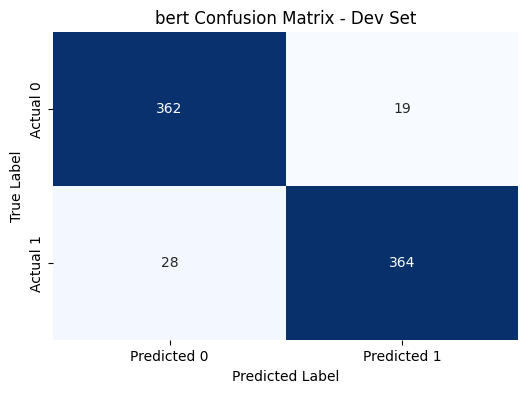

Plot saved: results/bert/confusion_test_bert.png


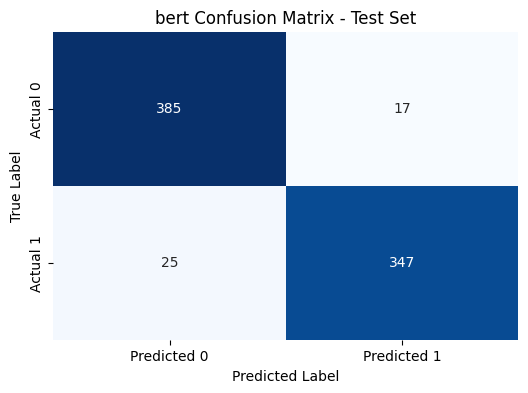

In [ ]:
# Dev set confusion matrix
y_true_dev = [x['labels'] for x in dev_dataset]
y_pred_dev = predictions_output_dev.predictions.argmax(axis=1)

cm_dev = confusion_matrix(y_true_dev, y_pred_dev)
plt.figure(figsize=(6,4))
sns.heatmap(cm_dev, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{MODEL_NAME} Confusion Matrix - Dev Set')

file_name = f"results/{MODEL_NAME}/confusion_dev_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# Test set confusion matrix
y_true_test = [x['labels'] for x in test_dataset]
y_pred_test = predictions_output_test.predictions.argmax(axis=1)

cm_test = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{MODEL_NAME} Confusion Matrix - Test Set')

file_name = f"results/{MODEL_NAME}/confusion_test_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

Plot saved: results/bert/pr_test_bert.png


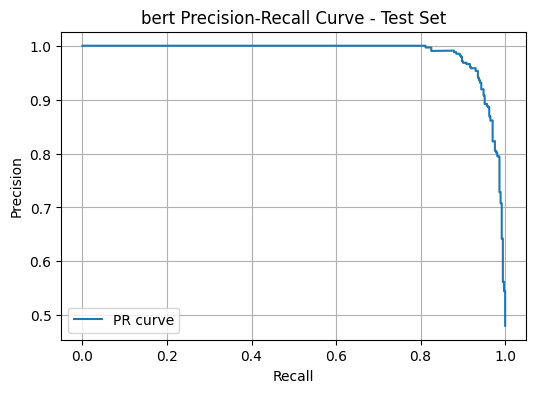

Plot saved: results/bert/pr_dev_bert.png


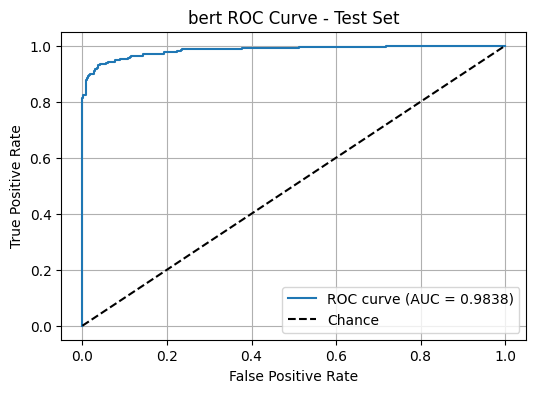

Plot saved: results/bert/learning_curve_bert.png


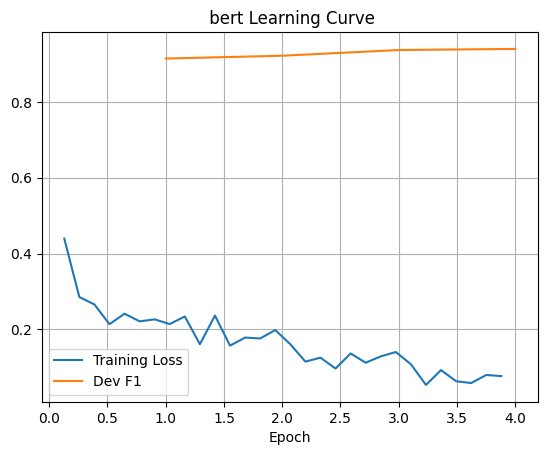

In [ ]:
# pr curve for dev
y_true_dev = [x['labels'] for x in dev_dataset]
if hasattr(predictions_output_dev, "probabilities"):
    y_scores_dev = predictions_output_dev.probabilities[:,1]
else:
    y_scores_dev = torch.softmax(torch.tensor(predictions_output_dev.predictions), dim=1)[:,1].numpy()

precision_dev, recall_dev, pr_thresholds_dev = precision_recall_curve(y_true_dev, y_scores_dev)
pr_auc_dev = auc(recall_dev, precision_dev)

plt.figure(figsize=(6,4))
plt.plot(recall_dev, precision_dev, label=f'PR curve (AUC={pr_auc_dev:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{MODEL_NAME} Precision-Recall Curve - Dev Set')
plt.grid()
plt.legend()

file_name = f"results/{MODEL_NAME}/pr_dev_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# Precision-Recall curve for Test Set
y_true_test = [x['labels'] for x in test_dataset]
if hasattr(predictions_output_test, "probabilities"):
    # HuggingFace >= v4.35.0
    y_scores_test = predictions_output_test.probabilities[:,1]
else:
    # fallback to logits
    y_scores_test = torch.softmax(torch.tensor(predictions_output_test.predictions), dim=1)[:,1].numpy()

precision_test, recall_test, pr_thresholds_test = precision_recall_curve(y_true_test, y_scores_test)
pr_auc_test = auc(recall_test, precision_test)

plt.figure(figsize=(6,4))
plt.plot(recall_test, precision_test, label=f'PR curve (AUC={pr_auc_test:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{MODEL_NAME} Precision-Recall Curve - Test Set')
plt.grid()
plt.legend()

file_name = f"results/{MODEL_NAME}/pr_test_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# ROC curve for Test Set
fpr, tpr, roc_thresholds = roc_curve(y_true_test, y_scores_test)
roc_auc = roc_auc_score(y_true_test, y_scores_test)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{MODEL_NAME} ROC Curve - Test Set')
plt.grid()
plt.legend()

file_name = f"results/{MODEL_NAME}/roc_test_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# Learning curve: training loss and dev F1 vs. epoch
training_logs = []
dev_f1s = []
epochs = []

if hasattr(trainer, "state") and hasattr(trainer.state, "log_history"):
    log_history = trainer.state.log_history
else:
    log_history = []

for log in log_history:
    if "loss" in log and "epoch" in log:
        training_logs.append((log["epoch"], log["loss"]))
    if "eval_f1" in log and "epoch" in log:
        dev_f1s.append((log["epoch"], log["eval_f1"]))

if training_logs:
    train_loss_df = pd.DataFrame(training_logs, columns=['epoch', 'train_loss'])
    train_loss_df = train_loss_df.groupby('epoch').mean().reset_index()
    plt.plot(train_loss_df['epoch'], train_loss_df['train_loss'], label="Training Loss")
if dev_f1s:
    dev_f1_df = pd.DataFrame(dev_f1s, columns=['epoch', 'dev_f1'])
    dev_f1_df = dev_f1_df.groupby('epoch').max().reset_index()
    plt.plot(dev_f1_df['epoch'], dev_f1_df['dev_f1'], label="Dev F1")

plt.xlabel("Epoch")
plt.title(f" {MODEL_NAME} Learning Curve")
plt.legend()
plt.grid()

file_name = f"results/{MODEL_NAME}/learning_curve_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

## Ablations

In [ ]:
# Threshold tuning ablation
print("=== Threshold Tuning Ablation ===")

# Use dev set scores
dev_scores = y_scores_dev
dev_probs = y_scores_dev

thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for threshold in thresholds:
    dev_preds_thresh = (dev_probs >= threshold).astype(int)
    threshold_results.append({
        'threshold': threshold,
        'f1': f1_score(y_true_dev, dev_preds_thresh),
        'precision': precision_score(y_true_dev, dev_preds_thresh),
        'recall': recall_score(y_true_dev, dev_preds_thresh),
        'accuracy': accuracy_score(y_true_dev, dev_preds_thresh)
    })

threshold_df = pd.DataFrame(threshold_results)

# maximize f1
optimal_idx = threshold_df['f1'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
print(f"Optimal threshold (max F1): {optimal_threshold:.3f}")
print(f"F1 at optimal threshold: {threshold_df.loc[optimal_idx, 'f1']:.4f}")
print(f"Precision: {threshold_df.loc[optimal_idx, 'precision']:.4f}")
print(f"Recall: {threshold_df.loc[optimal_idx, 'recall']:.4f}")

# default (0.5)
default_idx = (threshold_df['threshold'] - 0.5).abs().idxmin()
print(f"Default threshold (0.5):")
print(f"  F1: {threshold_df.loc[default_idx, 'f1']:.4f}")
print(f"  Precision: {threshold_df.loc[default_idx, 'precision']:.4f}")
print(f"  Recall: {threshold_df.loc[default_idx, 'recall']:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(threshold_df['threshold'], threshold_df['f1'], marker='o', label='F1', linewidth=2)
plt.plot(threshold_df['threshold'], threshold_df['precision'], marker='s', label='precision', linewidth=2)
plt.plot(threshold_df['threshold'], threshold_df['recall'], marker='^', label='recall', linewidth=2)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'best threshold ({optimal_threshold:.3f})')
plt.axvline(x=0.5, color='gray', linestyle='--', label='default threshold (0.5)', alpha=0.5)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'{MODEL_NAME}: Threshold Tuning on Dev Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

file_name = f"results/{MODEL_NAME}/ablation_threshold_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")
plt.show()

test_probs = y_scores_test
test_preds_optimal = (test_probs >= optimal_threshold).astype(int)
test_preds_default = (test_probs >= 0.5).astype(int)

print("=== Test Set Performance ===")
print(f"Default threshold (0.5):")
print(f"  F1: {f1_score(y_true_test, test_preds_default):.4f}")
print(f"  Precision: {precision_score(y_true_test, test_preds_default):.4f}")
print(f"  Recall: {recall_score(y_true_test, test_preds_default):.4f}")

print(f"Optimal threshold ({optimal_threshold:.3f}):")
print(f"  F1: {f1_score(y_true_test, test_preds_optimal):.4f}")
print(f"  Precision: {precision_score(y_true_test, test_preds_optimal):.4f}")
print(f"  Recall: {recall_score(y_true_test, test_preds_optimal):.4f}")


Plot saved: results/bert/most_bert.png


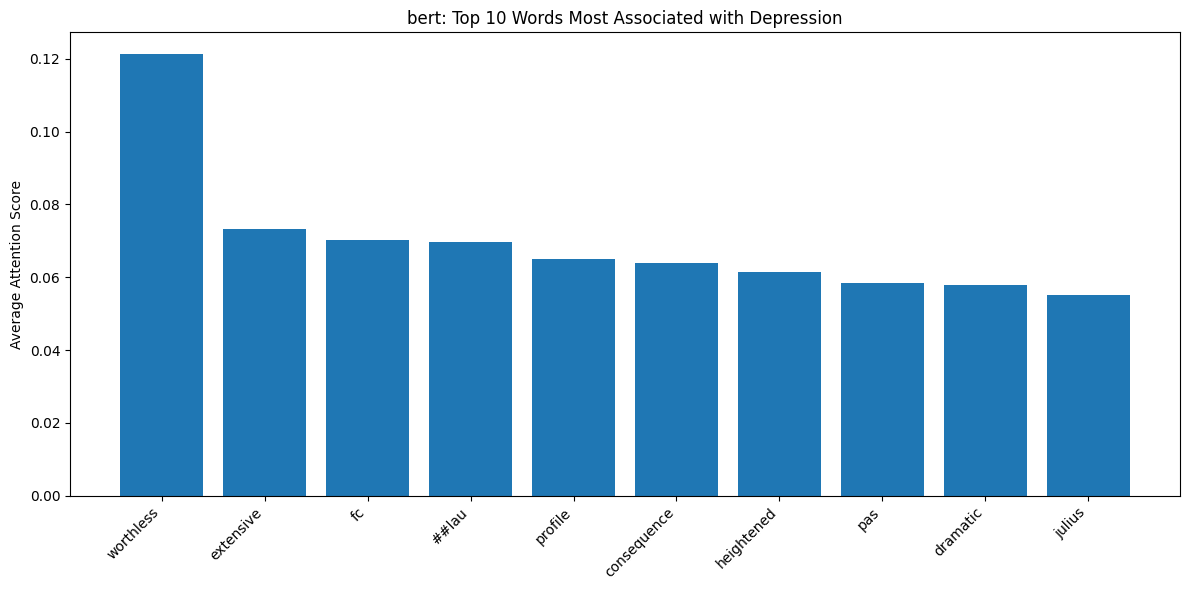

Plot saved: results/bert/least_bert.png


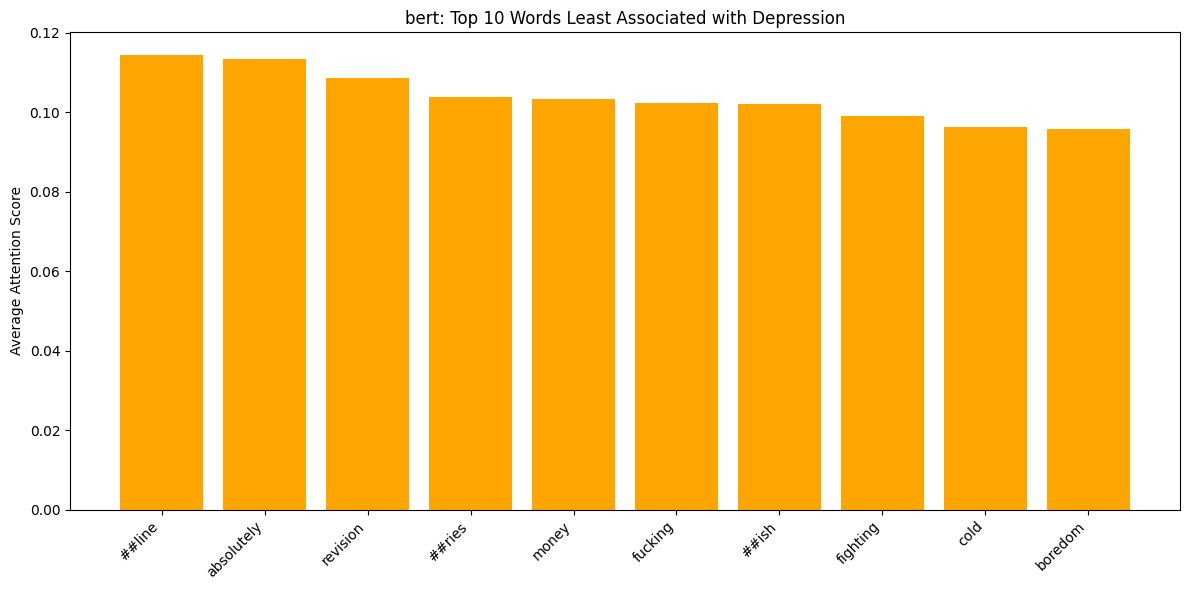

In [ ]:
import torch.nn.functional as F
from collections import defaultdict

def get_attention_weights(model, tokenizer, texts, device='cpu'):
    """
    Extract attention weights from BERT for given texts.
    Returns token-level importance scores.
    """
    model.eval()
    token_importance = defaultdict(float)
    token_counts = defaultdict(int)

    with torch.no_grad():
        for text in texts[:100]:
            inputs = tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                max_length=MAX_LENGTH,
                padding=True
            ).to(device)

            outputs = model(**inputs, output_attentions=True)
            attentions = outputs.attentions

            avg_attention = torch.stack(attentions).mean(dim=(0, 2))
            # shape is (batch_size, seq_len, seq_len)

            cls_attention = avg_attention[0, 0, :]

            tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

            for token, score in zip(tokens, cls_attention.cpu().numpy()):
                if token not in ['[CLS]', '[SEP]', '[PAD]']:
                    token_importance[token] += score
                    token_counts[token] += 1

    avg_importance = {token: token_importance[token] / token_counts[token]
                     for token in token_importance}

    return avg_importance

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert.to(device)

depression_texts = [text for text, label in zip(test_text, test_dep) if label == 1][:100]
non_depression_texts = [text for text, label in zip(test_text, test_dep) if label == 0][:100]

depression_importance = get_attention_weights(bert, tokenizer, depression_texts, device)
non_depression_importance = get_attention_weights(bert, tokenizer, non_depression_texts, device)

# Get top k most important tokens for depression
k = 10
sorted_dep = sorted(depression_importance.items(), key=lambda x: x[1], reverse=True)[:k]
sorted_non_dep = sorted(non_depression_importance.items(), key=lambda x: x[1], reverse=True)[:k]

# =================================================
# top k words MOST associated with depression
# =================================================
tokens_dep, scores_dep = zip(*sorted_dep)
plt.figure(figsize=(12, 6))
plt.bar(range(len(tokens_dep)), scores_dep)
plt.xticks(range(len(tokens_dep)), tokens_dep, rotation=45, ha='right')
plt.ylabel('Average Attention Score')
plt.title(f'{MODEL_NAME}: Top {k} Words Most Associated with Depression')
plt.tight_layout()

file_name = f"results/{MODEL_NAME}/most_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# =================================================
# top k words LEAST associated with depression
# =================================================
tokens_non_dep, scores_non_dep = zip(*sorted_non_dep)
plt.figure(figsize=(12, 6))
plt.bar(range(len(tokens_non_dep)), scores_non_dep, color='orange')
plt.xticks(range(len(tokens_non_dep)), tokens_non_dep, rotation=45, ha='right')
plt.ylabel('Average Attention Score')
plt.title(f'{MODEL_NAME}: Top {k} Words Least Associated with Depression')
plt.tight_layout()

file_name = f"results/{MODEL_NAME}/least_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()